In [2]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets
from torchvision import transforms
import PIL
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim



    

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20), 
    transforms.ColorJitter(),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset_path = "../Data/train"
# Tüm veriyi "taklalı" gözlükle yükle
full_dataset_train = torchvision.datasets.ImageFolder(dataset_path, transform=train_transforms)
# Tüm veriyi "temiz" gözlükle yükle
full_dataset_val = torchvision.datasets.ImageFolder(dataset_path, transform=val_transforms)



total_data = len(full_dataset_train)
train_size = int(total_data * 0.85)
val_size = total_data - train_size

indices = torch.randperm(total_data).tolist()
train_set = torch.utils.data.Subset(full_dataset_train, indices[:train_size])
val_set = torch.utils.data.Subset(full_dataset_val, indices[train_size:])

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader= torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

train_image, train_label = next(iter(train_loader))
print(f"Toplam Veri: {total_data}")
print(f"Eğitim Seti: {len(train_set)} resim")
print(f"Test Seti: {len(val_set)} resim")
print(f"Batch Şekli (1 Paketteki Resimler): {train_image.shape}")

Toplam Veri: 8000
Eğitim Seti: 6800 resim
Test Seti: 1200 resim
Batch Şekli (1 Paketteki Resimler): torch.Size([32, 3, 224, 224])


In [14]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


train_labels = full_dataset_train.targets
calculated_graphs = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y = train_labels
)

weight_tensor = torch.FloatTensor(calculated_graphs).to(device)

print("Sınıf Ağırlıkları (Cezalar):", weight_tensor)

criterion = nn.CrossEntropyLoss(weight=weight_tensor)


Using device: cuda
Sınıf Ağırlıkları (Cezalar): tensor([ 4.3956,  2.7943,  1.3031, 12.5589,  1.2841,  0.2131, 10.2960],
       device='cuda:0')


In [15]:
num_classes = 7
class SkinCancerModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,kernel_size=3,padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(50176,128)
        self.fc2 = nn.Linear(128,num_classes)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        
        x = self.flatten(x)

       
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        
        return x
    
model_v3 = SkinCancerModelV2()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

criterion= nn.CrossEntropyLoss(weight_tensor)
optimizer = optim.Adam(model_v3.parameters(),lr=0.0001)
model_v3.to(device)
model_v3.train()

for epoch in range(15):
    total_loss = 0
    total_accuary = 0
    for image ,label in train_loader:
        image = image.to(device)
        label= label.to(device)
        predict = model_v3(image)
        hata = criterion(predict,label)

        optimizer.zero_grad()
        hata.backward()
        optimizer.step()

        total_loss += hata.item()

        tahmin_edilenler = torch.argmax(predict,dim=1)
        paket_dogrusu = (tahmin_edilenler == label).sum().item()
        total_accuary += paket_dogrusu

    ortalama_hata = total_loss / len(train_loader)

    yuzdelik_basari = (total_accuary / len(train_loader.dataset)) * 100

    print(f"Epoch {epoch+1} tamamlandı. Ortalama Hata: {total_loss/len(train_loader)},Yüzdelik Başari: {yuzdelik_basari}")


Using device: cuda
Epoch 1 tamamlandı. Ortalama Hata: 1.9084756060945036,Yüzdelik Başari: 42.661764705882355
Epoch 2 tamamlandı. Ortalama Hata: 1.792082816222464,Yüzdelik Başari: 50.955882352941174
Epoch 3 tamamlandı. Ortalama Hata: 1.7265044814544104,Yüzdelik Başari: 50.220588235294116
Epoch 4 tamamlandı. Ortalama Hata: 1.679551491714979,Yüzdelik Başari: 50.48529411764706
Epoch 5 tamamlandı. Ortalama Hata: 1.6643983702144713,Yüzdelik Başari: 49.411764705882355
Epoch 6 tamamlandı. Ortalama Hata: 1.6352850570924964,Yüzdelik Başari: 49.14705882352941
Epoch 7 tamamlandı. Ortalama Hata: 1.6115989942505886,Yüzdelik Başari: 50.23529411764706
Epoch 8 tamamlandı. Ortalama Hata: 1.5970641021997156,Yüzdelik Başari: 49.64705882352941
Epoch 9 tamamlandı. Ortalama Hata: 1.5609098947104154,Yüzdelik Başari: 51.01470588235294
Epoch 10 tamamlandı. Ortalama Hata: 1.54382204002058,Yüzdelik Başari: 49.85294117647059
Epoch 11 tamamlandı. Ortalama Hata: 1.5126169794042346,Yüzdelik Başari: 49.35294117647059


🎉 TEST SONUCU | Ortalama Hata: 1.1857 | Başarı Oranı: %49.58


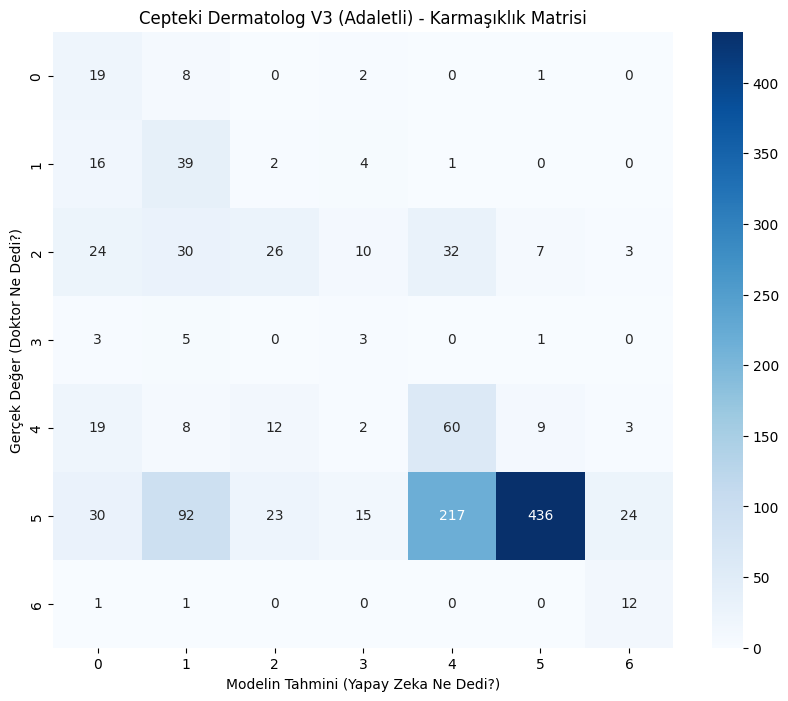

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model_v3.eval()
model_v3 =model_v3.to(device)
criterion= nn.CrossEntropyLoss()
gercek_etiketler = []
modelin_tahminleri = []
 
with torch.no_grad():

    total_loss = 0
    total_accuary = 0

    for image ,label in val_loader:
        image , label = image.to(device),label.to(device)
        predict = model_v3(image)
        hata = criterion(predict,label)

        total_loss += hata.item()

        tahmin_edilenler = torch.argmax(predict,dim=1)

        paket_dogrusu = (tahmin_edilenler == label).sum().item()
        total_accuary += paket_dogrusu

        modelin_tahminleri.extend(tahmin_edilenler.cpu().numpy())
        gercek_etiketler.extend(label.cpu().numpy())

    ortalama_hata = total_loss / len(val_loader)

    yuzdelik_basari = (total_accuary / len(val_loader.dataset)) * 100

    print(f"🎉 TEST SONUCU | Ortalama Hata: {ortalama_hata:.4f} | Başarı Oranı: %{yuzdelik_basari:.2f}")




cm = confusion_matrix(gercek_etiketler, modelin_tahminleri)

# 2. Şık Bir Tablo (Heatmap) Olarak Çizdir
plt.figure(figsize=(10, 8)) # Tablonun boyutu
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') # annot=True sayıları gösterir, cmap renk tonudur
plt.xlabel('Modelin Tahmini (Yapay Zeka Ne Dedi?)')
plt.ylabel('Gerçek Değer (Doktor Ne Dedi?)')
plt.title('Cepteki Dermatolog V3 (Adaletli) - Karmaşıklık Matrisi')
plt.show()
    
